## Dependencies

In [1]:
# Dependencies to Visualize the model
%matplotlib inline
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

In [3]:
# Filepaths, pandas, numpy, Tensorflow, and scikit-image
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import skimage as sk


In [4]:
# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

### Keras Specific Dependencies

In [5]:
# Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist

## Loading and Preprocessing our Data

### Load the Skin Cancer Image Dataset and Metadata

Number of images loaded: 10015


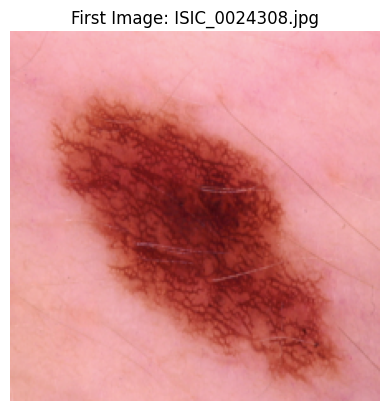

In [7]:
from PIL import Image

# Define folder path where images are stored
folder_path = "Resources/Skin Cancer/Split"

# Load images
def load_images_from_folder(folder_path, image_size=(224, 224)):
    """
    Load images from all subfolders of a given folder and resize them to a specified size.
    
    Args:
    - folder_path (str): The path to the folder containing the subfolders.
    - image_size (tuple, optional): The desired size of the images. Defaults to (224, 224).

    
    Returns:
    - images (list): A list of tuples, where each tuple contains a filename and its corresponding, resized image.
    """
    images = []
    # Iterate over all subfolders and their contents
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg"):
                file_path = os.path.join(root, file)
                img = Image.open(file_path)
                if img is not None:
                    img = img.resize(image_size)
                    images.append((file, img))  # Storing filename along with the image
    return images

# Call function to define images
images = load_images_from_folder(folder_path)

# Check that all 10,015 images were loaded
print("Number of images loaded:", len(images))

# Check first image
if images:
    # Extract the first image from the list
    first_filename, first_image = images[0]
    
    # Display the first image
    plt.imshow(first_image)
    plt.title("First Image: " + first_filename)  # Add title with filename
    plt.axis('off')  # Turn off axis
    plt.show()

In [8]:
# Define csv file name
csv_file = "Resources/HAM10000_metadata.csv"

# Load metadata csv
def load_metadata_from_csv(csv_file):
    """
    Load metadata from a CSV file and return it as a DataFrame.
    
    Args:
    - csv_file (str): The path to the CSV file containing the metadata.
    
    Returns:
    - metadata (DataFrame): A DataFrame containing the metadata read from the CSV file.
    """
    metadata = pd.read_csv(csv_file)
    return metadata

# Call function to define metadata
metadata = load_metadata_from_csv(csv_file)

# Preview pandas dataframe to confirm metadata loaded correctly
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
# Match images with metadata based on filenames
def match_images_with_metadata(images, metadata):
    """
    Match images with metadata based on filenames.

    Args:
    - images (list): A list of tuples containing (filename, image).
    - metadata (DataFrame): A DataFrame containing metadata.

    Returns:
    - matched_data (list): A list of tuples containing (filename, image, matched metadata row).
    """
    matched_data = []
    for filename, img in images:
        # Extract the filename without extension
        filename_without_ext = os.path.splitext(filename)[0]
        # Find corresponding row in metadata with matching filename
        matched_row = metadata.loc[metadata['image_id'] == filename_without_ext]
        # If a match is found, store the image and metadata together
        if not matched_row.empty:
            matched_data.append((filename, img, matched_row))
    return matched_data

# Call function to define matched_data
matched_data = match_images_with_metadata(images, metadata)

# Check that all 10,015 images were matched with metadata
print("Number of matched images and metadata:", len(matched_data))

Number of matched images and metadata: 10015


In [10]:
# Create pandas dataframe of metadata matched with corresponding image
def create_metadata_image_dataframe(matched_data):
    """
    Create a DataFrame containing metadata with corresponding images.
    
    Args:
    - matched_data (list): A list of tuples containing (filename, image, metadata_row).
    
    Returns:
    - df (DataFrame): A DataFrame where each row corresponds to a matched image and its metadata.
    """
    data = []
    for filename, img, metadata_row in matched_data:
        metadata_dict = metadata_row.to_dict(orient='records')[0]  # Convert metadata row to dictionary
        metadata_dict['Image'] = img  # Add the image to the metadata dictionary
        data.append(metadata_dict)
    df = pd.DataFrame(data)
    return df

# Call function to define metadata_image_df
metadata_image_df = create_metadata_image_dataframe(matched_data)

# Preview dataframe
metadata_image_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...
1,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...
2,HAM_0002450,ISIC_0024318,df,consensus,65.0,female,lower extremity,<PIL.Image.Image image mode=RGB size=224x224 a...
3,HAM_0003062,ISIC_0024319,nv,histo,55.0,male,lower extremity,<PIL.Image.Image image mode=RGB size=224x224 a...
4,HAM_0005039,ISIC_0024320,nv,follow_up,65.0,male,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...


## Image Color Analysis

### HSV Color Analysis

In [25]:
from skimage import color

def calculate_hsv_histogram(image):
    """
    Calculate HSV histograms for an image.

    Parameters:
    - image: PIL.Image.Image object representing the input image.

    Returns:
    - hsv_histogram: NumPy array containing the flattened concatenated histograms of hue, saturation, and value.
    """
    # Convert PIL Image to NumPy array
    image_array = np.array(image)

    # Convert the image to HSV color space
    hsv_image = color.rgb2hsv(image_array)

    # Calculate histograms for each component (Hue, Saturation, Value)
    hue_histogram, _ = np.histogram(hsv_image[:,:,0], bins=180, range=(0, 1))
    saturation_histogram, _ = np.histogram(hsv_image[:,:,1], bins=256, range=(0, 1))
    value_histogram, _ = np.histogram(hsv_image[:,:,2], bins=256, range=(0, 1))

    # Concatenate and flatten the histograms
    hsv_histogram = np.concatenate((hue_histogram, saturation_histogram, value_histogram)).flatten()

    return hsv_histogram

# Create a new DataFrame based on metadata_image_df
hsv_metadata_image_df = metadata_image_df.copy()

# Calculate HSV histograms and assign them to the new DataFrame
hsv_metadata_image_df['hsv_histogram'] = hsv_metadata_image_df['Image'].apply(calculate_hsv_histogram)

# Display the updated DataFrame
hsv_metadata_image_df.head()



,lesion_id,image_id,dx,dx_type,age,sex,localization,Image,hue_histogram,saturation_histogram,value_histogram,red_histogram,green_histogram,blue_histogram,hsv_histogram
0,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...,"[7592, 6168, 4903, 4101, 1853, 367, 7, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 6, 7, 14, 30...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, ...","[7592, 6168, 4903, 4101, 1853, 367, 7, 0, 0, 0..."
1,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...,"[1681, 492, 122, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1681, 492, 122, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,HAM_0002450,ISIC_0024318,df,consensus,65.0,female,lower extremity,<PIL.Image.Image image mode=RGB size=224x224 a...,"[2078, 2196, 2975, 4793, 8209, 9674, 7609, 445...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2078, 2196, 2975, 4793, 8209, 9674, 7609, 445..."
3,HAM_0003062,ISIC_0024319,nv,histo,55.0,male,lower extremity,<PIL.Image.Image image mode=RGB size=224x224 a...,"[100, 142, 278, 508, 1113, 1467, 1946, 2079, 3...","[4, 5, 3, 2, 2, 1, 1, 0, 0, 2, 1, 1, 1, 1, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[100, 142, 278, 508, 1113, 1467, 1946, 2079, 3..."
4,HAM_0005039,ISIC_0024320,nv,follow_up,65.0,male,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...,"[7972, 7581, 7601, 5889, 2690, 738, 137, 20, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7972, 7581, 7601, 5889, 2690, 738, 137, 20, 1..."


### RGB Color Analysis

In [26]:
def calculate_rgb_histogram(image):
    """
    Calculate RGB histograms for an image.

    Parameters:
    - image: PIL.Image.Image object representing the input image.

    Returns:
    - rgb_histogram: NumPy array containing the flattened concatenated histograms of red, green, and blue channels.
    """
    # Convert PIL Image to NumPy array
    image_array = np.array(image)

    # Calculate histograms for each RGB channel
    red_histogram, _ = np.histogram(image_array[:,:,0], bins=256, range=(0, 255))
    green_histogram, _ = np.histogram(image_array[:,:,1], bins=256, range=(0, 255))
    blue_histogram, _ = np.histogram(image_array[:,:,2], bins=256, range=(0, 255))

    # Concatenate and flatten the histograms
    rgb_histogram = np.concatenate((red_histogram, green_histogram, blue_histogram)).flatten()

    return rgb_histogram

# Create a new DataFrame based on metadata_image_df
rgb_metadata_image_df = metadata_image_df.copy()

# Calculate RGB histograms and assign them to the new DataFrame
rgb_metadata_image_df['rgb_histogram'] = rgb_metadata_image_df['Image'].apply(calculate_rgb_histogram)

# Display the updated DataFrame
rgb_metadata_image_df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,Image,hue_histogram,saturation_histogram,value_histogram,red_histogram,green_histogram,blue_histogram,rgb_histogram
0,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...,"[7592, 6168, 4903, 4101, 1853, 367, 7, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 6, 7, 14, 30...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...,"[1681, 492, 122, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,HAM_0002450,ISIC_0024318,df,consensus,65.0,female,lower extremity,<PIL.Image.Image image mode=RGB size=224x224 a...,"[2078, 2196, 2975, 4793, 8209, 9674, 7609, 445...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,HAM_0003062,ISIC_0024319,nv,histo,55.0,male,lower extremity,<PIL.Image.Image image mode=RGB size=224x224 a...,"[100, 142, 278, 508, 1113, 1467, 1946, 2079, 3...","[4, 5, 3, 2, 2, 1, 1, 0, 0, 2, 1, 1, 1, 1, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,HAM_0005039,ISIC_0024320,nv,follow_up,65.0,male,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...,"[7972, 7581, 7601, 5889, 2690, 738, 137, 20, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#Run through classifiers for black and white before moving to color
#Once we get to the point where we are tuning, loot at the differnet filters for convolutional neural networks
#Play with the different steps sizes
#Play around with pooling stages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [36]:
# Preprocess the image data
X = np.array([np.array(img) for _, img, _ in matched_data])
X = X / 255.0  # Normalize pixel values to [0, 1]
y = pd.get_dummies(metadata_image_df['dx'], dtype=int).values  # One-hot encode the target labels
print(X)
print(y)

[[[[0.96470588 0.6745098  0.70980392]
   [0.96862745 0.68235294 0.70980392]
   [0.96470588 0.6745098  0.69019608]
   ...
   [0.96078431 0.65098039 0.70588235]
   [0.96862745 0.65882353 0.70980392]
   [0.96862745 0.6627451  0.70980392]]

  [[0.96470588 0.67843137 0.71372549]
   [0.96470588 0.68235294 0.72156863]
   [0.96470588 0.67058824 0.69019608]
   ...
   [0.95686275 0.65098039 0.69803922]
   [0.96078431 0.65882353 0.70980392]
   [0.97254902 0.65490196 0.71764706]]

  [[0.96470588 0.68235294 0.71372549]
   [0.96078431 0.6745098  0.70588235]
   [0.96078431 0.67058824 0.70196078]
   ...
   [0.96078431 0.63921569 0.69019608]
   [0.95294118 0.63529412 0.68235294]
   [0.96470588 0.63921569 0.69411765]]

  ...

  [[0.91764706 0.6627451  0.62745098]
   [0.94117647 0.69019608 0.65490196]
   [0.9254902  0.65490196 0.61176471]
   ...
   [0.85098039 0.57647059 0.61176471]
   [0.84705882 0.57254902 0.60784314]
   [0.84705882 0.56078431 0.60392157]]

  [[0.92156863 0.67058824 0.64705882]
   [0.9

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

c:\Users\Andrew Koller\anaconda3\envs\tf_new\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 122s 476ms/step - accuracy: 0.6503 - loss: 1.1744 - val_accuracy: 0.6805 - val_loss: 0.8830
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 102s 405ms/step - accuracy: 0.6856 - loss: 0.8679 - val_accuracy: 0.7124 - val_loss: 0.8632
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 101s 401ms/step - accuracy: 0.7116 - loss: 0.7956 - val_accuracy: 0.7009 - val_loss: 0.8221
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 400ms/step - accuracy: 0.7260 - loss: 0.7426 - val_accuracy: 0.6610 - val_loss: 0.8569
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 101s 402ms/step - accuracy: 0.7256 - loss: 0.7186 - val_accuracy: 0.7039 - val_loss: 0.7983
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 399ms/step - accuracy: 0.7567 - loss: 0.6534 - val_accuracy: 0.7309 - val_loss: 0.7759
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 398ms/step - accuracy: 0.7743 - loss: 0.6132 - val_accuracy: 0.7114 - val_loss: 0.8509
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 100s 397ms/step - accuracy: 0.7869 -

In [32]:
print(y.astype(int))

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


In [27]:
# Prepare the histogram data
rgb_histograms = np.array(rgb_metadata_image_df[['red_histogram', 'green_histogram', 'blue_histogram']].values.tolist())
hsv_histograms = np.array(hsv_metadata_image_df[['hue_histogram', 'saturation_histogram', 'value_histogram']].values.tolist())
X_hist = np.concatenate((rgb_histograms, hsv_histograms), axis=1)

# Normalize the histogram data if needed
X_hist = X_hist / X_hist.max(axis=1, keepdims=True)

# Prepare the target labels
y = pd.get_dummies(metadata_image_df['dx']).values

# Split the data into training and validation sets
X_train_hist, X_val_hist, y_train, y_val = train_test_split(X_hist, y, test_size=0.2, random_state=42)

# Define the CNN architecture
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_hist.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_hist, y_train, epochs=10, batch_size=32, validation_data=(X_val_hist, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val_hist, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10015, 3) + inhomogeneous part.